#### Installation Procedure

conda create --name tf_gpu tensorflow-gpu  
conda activate tf_gpu  
conda install -c anaconda keras-gpu  

#### Overview:

This project is based on the workflow as laid out by Chahhou Mohammed, winner of the Kaggle $1 Million prize for price prediction on the Zillow dataset.  He systematically builds a simple model and gradually adds more complexity while performing grid-search over the hyperparameters.  Here we will perform this same task on the Kaggle dataset for NIH Chest X-ray images.

A link to Mohammed's workflow may be found here: <https://github.com/MIDS-scaling-up/v2/blob/master/week07/labs/README.md>

#### NIH Chest X-Ray Dataset

This dataset was gathered by the NIH and contains over 100,000 anonymized chest x-ray images from more than 30,000 patients.  The data represents NLP analysis of radiology reports and may include areas of lower confidence in diagnoses.  As a simplifying assumption, wee assume that based on the size of the dataset, that the dataset is accurate in diagnoses.

https://www.kaggle.com/nih-chest-xrays/data

Citations
Wang X, Peng Y, Lu L, Lu Z, Bagheri M, Summers RM. ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases. IEEE CVPR 2017, ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf

NIH News release: NIH Clinical Center provides one of the largest publicly available chest x-ray datasets to scientific community

Original source files and documents: https://nihcc.app.box.com/v/ChestXray-NIHCC/folder/36938765345

In [31]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
all_xray_df = pd.read_csv('./data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('.', 'data', 'images*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)

all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
57387,00014236_004.png,No Finding,4,14236,62,M,AP,2500,2048,0.168,0.168,NaN,.\data\images\00014236_004.png
63308,00015640_011.png,No Finding,11,15640,44,M,AP,2500,2048,0.168,0.168,NaN,.\data\images\00015640_011.png
49644,00012605_000.png,No Finding,0,12605,5,M,AP,2500,2048,0.168,0.168,NaN,.\data\images\00012605_000.png


# Preprocessing Labels
Here we take the labels and make them into a more clear format. The primary step is to see the distribution of findings and then to convert them to simple binary labels

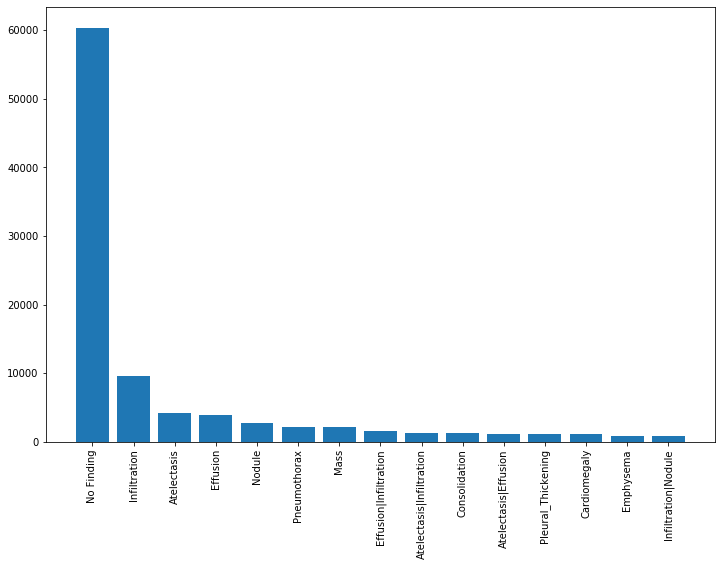

In [3]:
label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [4]:
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
17646,00004755_008.png,,8,4755,38,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27377,00007125_003.png,,3,7125,65,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12796,00003361_004.png,,4,3361,52,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
all_labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

### Clean categories
Since we have too many categories, we can prune a few out by taking the ones with only a few examples

In [6]:
# keep at least 1000 cases
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if all_xray_df[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(all_xray_df[c_label].sum())) for c_label in all_labels])

Clean Labels (13) [('Atelectasis', 11559), ('Cardiomegaly', 2776), ('Consolidation', 4667), ('Edema', 2303), ('Effusion', 13317), ('Emphysema', 2516), ('Fibrosis', 1686), ('Infiltration', 19894), ('Mass', 5782), ('Nodule', 6331), ('Pleural_Thickening', 3385), ('Pneumonia', 1431), ('Pneumothorax', 5302)]


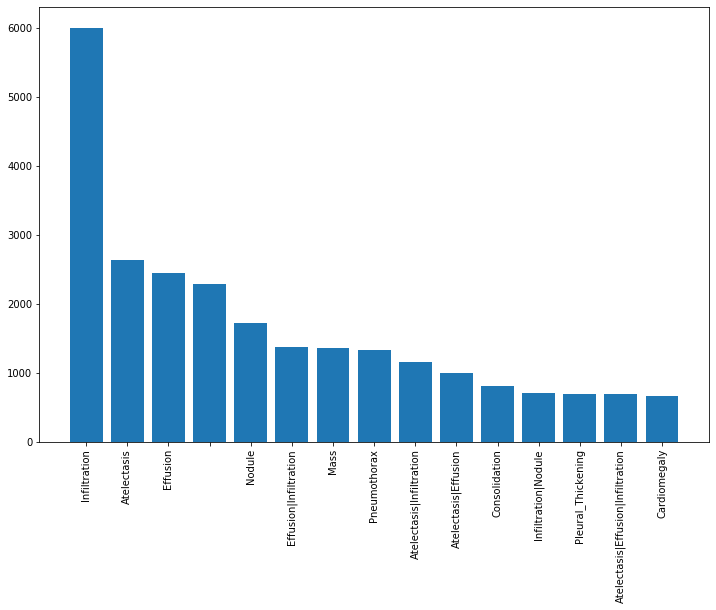

In [7]:
# since the dataset is very unbiased, we can resample it to be a more reasonable collection
# weight is 0.1 + number of findings
sample_weights = all_xray_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
all_xray_df = all_xray_df.sample(40000, weights=sample_weights)

label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

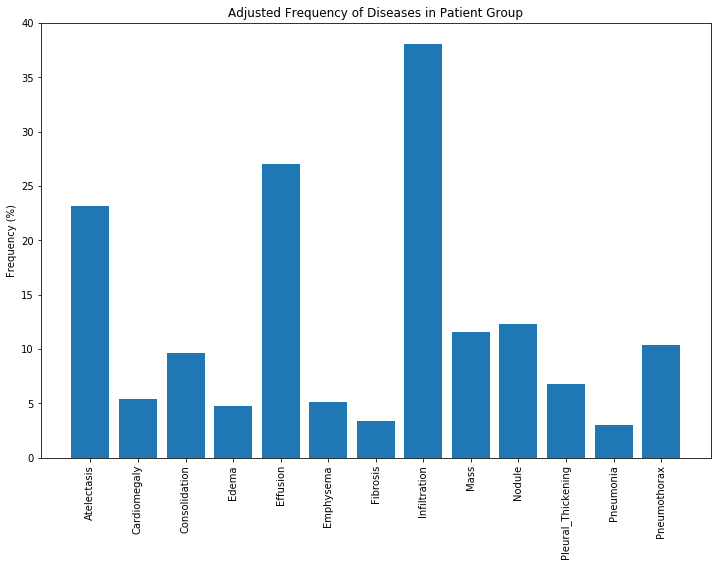

In [8]:
label_counts = 100*np.mean(all_xray_df[all_labels].values,0)
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
ax1.set_xticklabels(all_labels, rotation = 90)
ax1.set_title('Adjusted Frequency of Diseases in Patient Group')
_ = ax1.set_ylabel('Frequency (%)')

# Prepare Training Data
Here we split the data into training and validation sets and create a single vector (disease_vec) with the 0/1 outputs for the disease status (what the model will try and predict)

In [9]:
all_xray_df['disease_vec'] = all_xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

In [10]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(all_xray_df, 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = all_xray_df['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 30000 validation 10000


# Create Data Generators
Here we make the data generators for loading and randomly transforming images

In [11]:
valid_df['newLabel'] = valid_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
train_df['newLabel'] = train_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)

c:\users\bisedab\appdata\local\continuum\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
c:\users\bisedab\appdata\local\continuum\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [12]:
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (128, 128)
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

Using TensorFlow backend.


In [13]:
train_gen = core_idg.flow_from_dataframe(dataframe=train_df, 
                             directory=None,
                             x_col = 'path',
                            y_col = 'newLabel', 
                             class_mode = 'categorical',
                            classes = all_labels,
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 32)

valid_gen = core_idg.flow_from_dataframe(dataframe=valid_df, 
                             directory=None,
                             x_col = 'path',
                            y_col = 'newLabel', 
                             class_mode = 'categorical',
                            classes = all_labels,
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 256) # we can use much larger batches for evaluation

train_X, train_Y = next(core_idg.flow_from_dataframe(dataframe=train_df, 
                             directory=None,
                             x_col = 'path',
                            y_col = 'newLabel', 
                             class_mode = 'categorical',
                            classes = all_labels,
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 1024))

test_X, test_Y = next(core_idg.flow_from_dataframe(dataframe=valid_df, 
                             directory=None,
                             x_col = 'path',
                            y_col = 'newLabel', 
                             class_mode = 'categorical',
                            classes = all_labels,
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 1024))

Found 28236 validated image filenames belonging to 13 classes.
Found 9410 validated image filenames belonging to 13 classes.
Found 28236 validated image filenames belonging to 13 classes.
Found 9410 validated image filenames belonging to 13 classes.


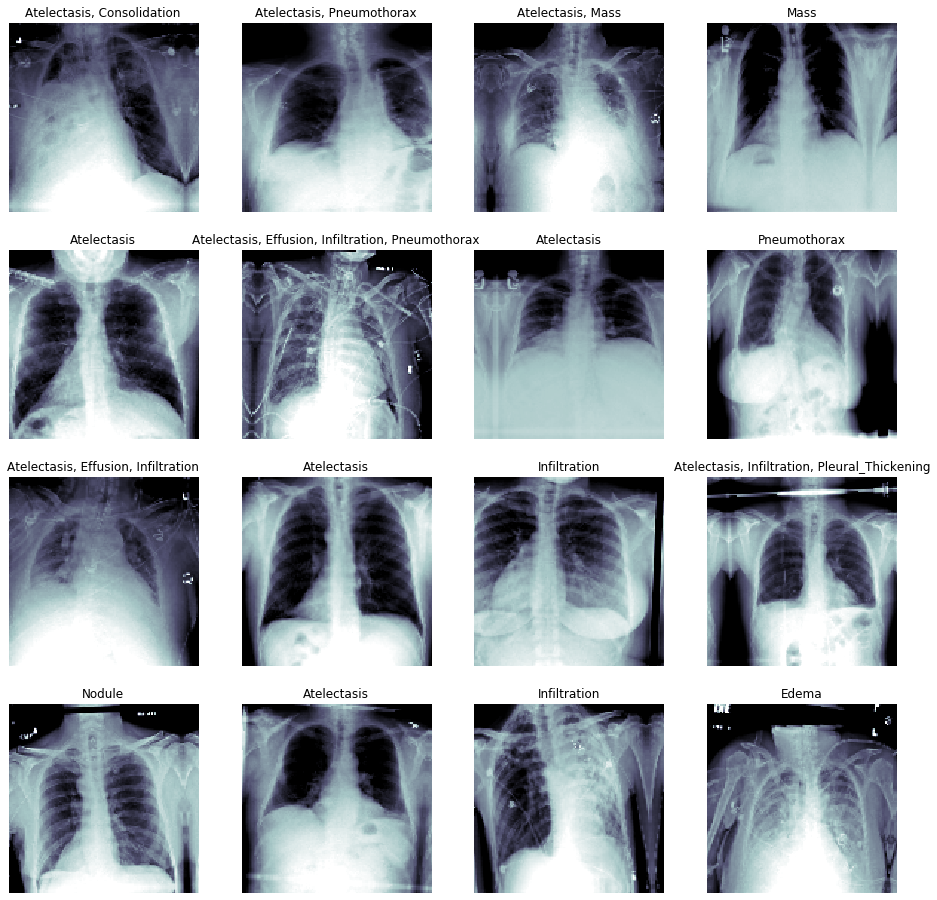

In [14]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

# Create a simple model
Here we make a simple model to train using MobileNet as a base and then adding a GAP layer (Flatten could also be added), dropout, and a fully-connected layer to calculate specific features

In [15]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
from keras import optimizers, callbacks, regularizers
base_mobilenet_model = MobileNet(input_shape =  t_x.shape[1:], 
                                 include_top = False, weights = None)
multi_disease_model = Sequential()
multi_disease_model.add(base_mobilenet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(len(all_labels), activation = 'sigmoid'))
multi_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
multi_disease_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_128 (Model)   (None, 4, 4, 1024)        3228288   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)      

In [16]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5)
callbacks_list = [checkpoint, early]

### Optimizer Selection

In [22]:
optimizers_list = [('sgd',optimizers.SGD( lr=.1) ),
                   ('sgd_momentum',optimizers.SGD(lr=.1, momentum=.9) ),
                   ('adagrad',optimizers.Adagrad()),
                   ('adadelta',optimizers.Adadelta()),
                   ('adam', optimizers.Adam()) 
                  ]

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5)

callbacks_list = [early, ModelCheckpoint( filepath=weight_path, monitor='val_loss', mode='min', save_best_only=True )]

Epoch 1/50
1000/1000 [==============================] - 391s 391ms/step - loss: 0.3386 - binary_accuracy: 0.8683 - mean_absolute_error: 0.2019 - val_loss: 0.3312 - val_binary_accuracy: 0.8706 - val_mean_absolute_error: 0.1982
Epoch 2/50
1000/1000 [==============================] - 381s 381ms/step - loss: 0.3349 - binary_accuracy: 0.8701 - mean_absolute_error: 0.1996 - val_loss: 0.3305 - val_binary_accuracy: 0.8721 - val_mean_absolute_error: 0.1956
Epoch 3/50
1000/1000 [==============================] - 381s 381ms/step - loss: 0.3341 - binary_accuracy: 0.8703 - mean_absolute_error: 0.1992 - val_loss: 0.3266 - val_binary_accuracy: 0.8721 - val_mean_absolute_error: 0.1970
Epoch 4/50
1000/1000 [==============================] - 383s 383ms/step - loss: 0.3321 - binary_accuracy: 0.8705 - mean_absolute_error: 0.1981 - val_loss: 0.3276 - val_binary_accuracy: 0.8718 - val_mean_absolute_error: 0.1950
Epoch 5/50
1000/1000 [==============================] - 379s 379ms/step - loss: 0.3300 - binary_

1000/1000 [==============================] - 364s 364ms/step - loss: 0.2662 - binary_accuracy: 0.8918 - mean_absolute_error: 0.1595 - val_loss: 0.3035 - val_binary_accuracy: 0.8808 - val_mean_absolute_error: 0.1687
Epoch 15/50
1000/1000 [==============================] - 365s 365ms/step - loss: 0.2645 - binary_accuracy: 0.8922 - mean_absolute_error: 0.1585 - val_loss: 0.3030 - val_binary_accuracy: 0.8780 - val_mean_absolute_error: 0.1681
Epoch 16/50
1000/1000 [==============================] - 363s 363ms/step - loss: 0.2635 - binary_accuracy: 0.8921 - mean_absolute_error: 0.1580 - val_loss: 0.3124 - val_binary_accuracy: 0.8745 - val_mean_absolute_error: 0.1669
Epoch 1/50
1000/1000 [==============================] - 381s 381ms/step - loss: 0.2896 - binary_accuracy: 0.8832 - mean_absolute_error: 0.1725 - val_loss: 0.3031 - val_binary_accuracy: 0.8797 - val_mean_absolute_error: 0.1696
Epoch 2/50
1000/1000 [==============================] - 379s 379ms/step - loss: 0.2919 - binary_accuracy:

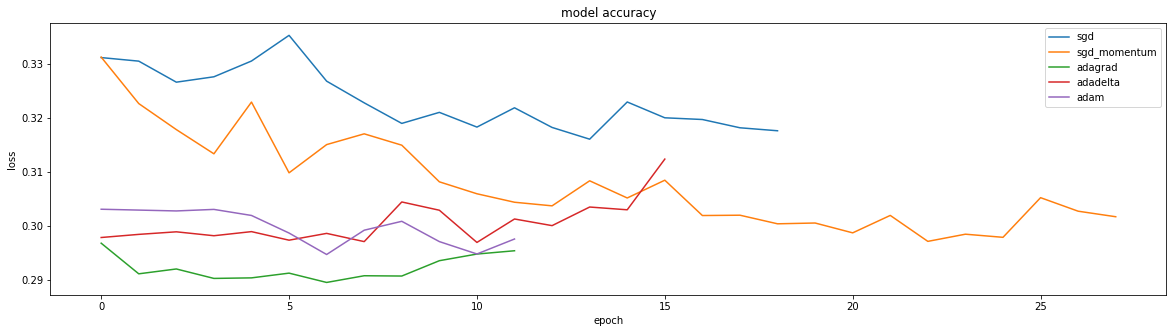

<Figure size 432x288 with 0 Axes>

In [23]:
plt.figure(figsize=(20,5))
for optimizer in optimizers_list:
    multi_disease_model.compile(optimizer = optimizer[1], loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
    
    history = multi_disease_model.fit_generator(train_gen, 
                                  steps_per_epoch=1000,
                                  validation_data = (test_X, test_Y), 
                                  epochs = 50, 
                                  callbacks = callbacks_list)
      
    
    plt.plot(history.history['val_loss'])
    
plt.legend([x[0] for x in optimizers_list], loc='upper right')
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()
plt.savefig('optimizer_selection.png', bbox_inches='tight')

While it appears that Adagrad, and adadelt may reach convergence faster, there is no substantially different loss as a result of optimizer selection.  When this function was run with larger numbers of training examples per epoch, adam outperformed (graphic not shown).  Based on the results shown in the figure above, we can accept the use of adam based on this particular dataset.

# Tuning Batch Size and the Learning Rate

In [24]:
# Gradient Accumulation Borrowed from following location:
# https://stackoverflow.com/questions/55268762/how-to-accumulate-gradients-for-large-batch-sizes-in-keras

import keras.backend as K
from keras.legacy import interfaces
from keras.optimizers import Optimizer

class AdamAccumulate(Optimizer):

    def __init__(self, lr=0.001, beta_1=0.9, beta_2=0.999,
                 epsilon=None, decay=0., amsgrad=False, accum_iters=1, **kwargs):
        if accum_iters < 1:
            raise ValueError('accum_iters must be >= 1')
        super(AdamAccumulate, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.lr = K.variable(lr, name='lr')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')
        if epsilon is None:
            epsilon = K.epsilon()
        self.epsilon = epsilon
        self.initial_decay = decay
        self.amsgrad = amsgrad
        self.accum_iters = K.variable(accum_iters, K.dtype(self.iterations))
        self.accum_iters_float = K.cast(self.accum_iters, K.floatx())

    @interfaces.legacy_get_updates_support
    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr

        completed_updates = K.cast(K.tf.floordiv(self.iterations, self.accum_iters), K.floatx())

        if self.initial_decay > 0:
            lr = lr * (1. / (1. + self.decay * completed_updates))

        t = completed_updates + 1

        lr_t = lr * (K.sqrt(1. - K.pow(self.beta_2, t)) / (1. - K.pow(self.beta_1, t)))

        # self.iterations incremented after processing a batch
        # batch:              1 2 3 4 5 6 7 8 9
        # self.iterations:    0 1 2 3 4 5 6 7 8
        # update_switch = 1:        x       x    (if accum_iters=4)  
        update_switch = K.equal((self.iterations + 1) % self.accum_iters, 0)
        update_switch = K.cast(update_switch, K.floatx())

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        gs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]

        if self.amsgrad:
            vhats = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        else:
            vhats = [K.zeros(1) for _ in params]

        self.weights = [self.iterations] + ms + vs + vhats

        for p, g, m, v, vhat, tg in zip(params, grads, ms, vs, vhats, gs):

            sum_grad = tg + g
            avg_grad = sum_grad / self.accum_iters_float

            m_t = (self.beta_1 * m) + (1. - self.beta_1) * avg_grad
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(avg_grad)

            if self.amsgrad:
                vhat_t = K.maximum(vhat, v_t)
                p_t = p - lr_t * m_t / (K.sqrt(vhat_t) + self.epsilon)
                self.updates.append(K.update(vhat, (1 - update_switch) * vhat + update_switch * vhat_t))
            else:
                p_t = p - lr_t * m_t / (K.sqrt(v_t) + self.epsilon)

            self.updates.append(K.update(m, (1 - update_switch) * m + update_switch * m_t))
            self.updates.append(K.update(v, (1 - update_switch) * v + update_switch * v_t))
            self.updates.append(K.update(tg, (1 - update_switch) * sum_grad))
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, (1 - update_switch) * p + update_switch * new_p))
        return self.updates

    def get_config(self):
        config = {'lr': float(K.get_value(self.lr)),
                  'beta_1': float(K.get_value(self.beta_1)),
                  'beta_2': float(K.get_value(self.beta_2)),
                  'decay': float(K.get_value(self.decay)),
                  'epsilon': self.epsilon,
                  'amsgrad': self.amsgrad}
        base_config = super(AdamAccumulate, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [25]:
#This was determined earlier in the training data loader
initialBS = 32
STEPS_PER_EPOCH = 1000
EPOCHS = 100

In [26]:
def MakeModel():
    model = Sequential()
    model.add(base_mobilenet_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(Dropout(0.5))
    model.add(Dense(len(all_labels), activation = 'sigmoid'))
    return model

### Here we set the steps per epoch and the batch size so regardless of learning rate, we are looking at the same number of examples

In [28]:
import gc
from collections import defaultdict
from sklearn.metrics import log_loss

run_this_code = True # This Code Block Takes a long time to run
if run_this_code:
    train_results = defaultdict(dict)
    test_results  = defaultdict(dict)

    for batch in [16, 8, 4, 2, 1]: #Number of batches before gradient accumulation
        for lr in [1e-4, 2e-4, 5e-4, 1e-3, 2e-3, 5e-3, 1e-2, 2e-2, 1e-1]:
            print ('Running Batch size : ', batch*initialBS, 'Learning Rate : ', lr)
            predictions_train = pd.DataFrame()
            predictions_test  = pd.DataFrame()
            
            opt = AdamAccumulate(lr=lr, accum_iters=batch) #Set the gradient accumulation value
            multi_disease_model = MakeModel()
            multi_disease_model.compile(optimizer = opt, loss = 'binary_crossentropy',
                   metrics = ['binary_accuracy', 'mae'])

            history = multi_disease_model.fit_generator(train_gen, 
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data = (test_X, test_Y), 
                          epochs = EPOCHS, 
                          callbacks = callbacks_list)

            multi_disease_model.load_weights(weight_path)

            p = history.history['val_loss'][0]

            del multi_disease_model, history
            gc.collect()
            print('*'*50)
            print('')

            test_results[batch][lr]  = p

Running Batch size :  512 Learning Rate :  0.0001
Epoch 1/100
1000/1000 [==============================] - 425s 425ms/step - loss: 0.3774 - binary_accuracy: 0.8538 - mean_absolute_error: 0.2503 - val_loss: 0.2956 - val_binary_accuracy: 0.8830 - val_mean_absolute_error: 0.1796
Epoch 2/100
1000/1000 [==============================] - 412s 412ms/step - loss: 0.2882 - binary_accuracy: 0.8862 - mean_absolute_error: 0.1720 - val_loss: 0.2917 - val_binary_accuracy: 0.8842 - val_mean_absolute_error: 0.1690
Epoch 3/100
1000/1000 [==============================] - 411s 411ms/step - loss: 0.2810 - binary_accuracy: 0.8876 - mean_absolute_error: 0.1669 - val_loss: 0.2908 - val_binary_accuracy: 0.8834 - val_mean_absolute_error: 0.1683
Epoch 4/100
1000/1000 [==============================] - 391s 391ms/step - loss: 0.2761 - binary_accuracy: 0.8891 - mean_absolute_error: 0.1643 - val_loss: 0.2916 - val_binary_accuracy: 0.8827 - val_mean_absolute_error: 0.1661
Epoch 5/100
1000/1000 [===================

Epoch 23/100
1000/1000 [==============================] - 424s 424ms/step - loss: 0.2788 - binary_accuracy: 0.8876 - mean_absolute_error: 0.1668 - val_loss: 0.2963 - val_binary_accuracy: 0.8821 - val_mean_absolute_error: 0.1720
Epoch 24/100
1000/1000 [==============================] - 419s 419ms/step - loss: 0.2790 - binary_accuracy: 0.8870 - mean_absolute_error: 0.1671 - val_loss: 0.2948 - val_binary_accuracy: 0.8817 - val_mean_absolute_error: 0.1743
**************************************************

Running Batch size :  512 Learning Rate :  0.01
Epoch 1/100
1000/1000 [==============================] - 453s 453ms/step - loss: 0.3605 - binary_accuracy: 0.8607 - mean_absolute_error: 0.2120 - val_loss: 0.3221 - val_binary_accuracy: 0.8752 - val_mean_absolute_error: 0.1940
Epoch 2/100
1000/1000 [==============================] - 415s 415ms/step - loss: 0.3278 - binary_accuracy: 0.8725 - mean_absolute_error: 0.1957 - val_loss: 0.3172 - val_binary_accuracy: 0.8764 - val_mean_absolute_erro

1000/1000 [==============================] - 418s 418ms/step - loss: 0.3036 - binary_accuracy: 0.8785 - mean_absolute_error: 0.1814 - val_loss: 0.2985 - val_binary_accuracy: 0.8818 - val_mean_absolute_error: 0.1782
Epoch 40/100
1000/1000 [==============================] - 417s 417ms/step - loss: 0.3022 - binary_accuracy: 0.8788 - mean_absolute_error: 0.1806 - val_loss: 0.2973 - val_binary_accuracy: 0.8815 - val_mean_absolute_error: 0.1749
Epoch 41/100
1000/1000 [==============================] - 418s 418ms/step - loss: 0.3022 - binary_accuracy: 0.8789 - mean_absolute_error: 0.1803 - val_loss: 0.3042 - val_binary_accuracy: 0.8777 - val_mean_absolute_error: 0.1876
Epoch 42/100
1000/1000 [==============================] - 417s 417ms/step - loss: 0.3007 - binary_accuracy: 0.8797 - mean_absolute_error: 0.1798 - val_loss: 0.3043 - val_binary_accuracy: 0.8825 - val_mean_absolute_error: 0.1842
Epoch 43/100
1000/1000 [==============================] - 419s 419ms/step - loss: 0.3004 - binary_acc

Epoch 3/100
1000/1000 [==============================] - 435s 435ms/step - loss: 0.2847 - binary_accuracy: 0.8855 - mean_absolute_error: 0.1705 - val_loss: 0.2950 - val_binary_accuracy: 0.8819 - val_mean_absolute_error: 0.1713
Epoch 4/100
1000/1000 [==============================] - 438s 438ms/step - loss: 0.2830 - binary_accuracy: 0.8860 - mean_absolute_error: 0.1694 - val_loss: 0.2965 - val_binary_accuracy: 0.8809 - val_mean_absolute_error: 0.1807
Epoch 5/100
1000/1000 [==============================] - 443s 443ms/step - loss: 0.2800 - binary_accuracy: 0.8874 - mean_absolute_error: 0.1675 - val_loss: 0.2971 - val_binary_accuracy: 0.8809 - val_mean_absolute_error: 0.1733
Epoch 6/100
1000/1000 [==============================] - 444s 444ms/step - loss: 0.2800 - binary_accuracy: 0.8871 - mean_absolute_error: 0.1680 - val_loss: 0.2928 - val_binary_accuracy: 0.8831 - val_mean_absolute_error: 0.1706
Epoch 7/100
1000/1000 [==============================] - 440s 440ms/step - loss: 0.2772 - bi

1000/1000 [==============================] - 517s 517ms/step - loss: 0.3726 - binary_accuracy: 0.8612 - mean_absolute_error: 0.2116 - val_loss: 0.3385 - val_binary_accuracy: 0.8701 - val_mean_absolute_error: 0.1986
Epoch 2/100
1000/1000 [==============================] - 453s 453ms/step - loss: 0.3413 - binary_accuracy: 0.8688 - mean_absolute_error: 0.2032 - val_loss: 0.3364 - val_binary_accuracy: 0.8701 - val_mean_absolute_error: 0.2025
Epoch 3/100
1000/1000 [==============================] - 458s 458ms/step - loss: 0.3408 - binary_accuracy: 0.8689 - mean_absolute_error: 0.2029 - val_loss: 0.3361 - val_binary_accuracy: 0.8701 - val_mean_absolute_error: 0.2000
Epoch 4/100
1000/1000 [==============================] - 456s 456ms/step - loss: 0.3412 - binary_accuracy: 0.8685 - mean_absolute_error: 0.2031 - val_loss: 0.3362 - val_binary_accuracy: 0.8701 - val_mean_absolute_error: 0.1933
Epoch 5/100
1000/1000 [==============================] - 456s 456ms/step - loss: 0.3400 - binary_accurac

Epoch 10/100
1000/1000 [==============================] - 491s 491ms/step - loss: 0.2664 - binary_accuracy: 0.8917 - mean_absolute_error: 0.1600 - val_loss: 0.3010 - val_binary_accuracy: 0.8794 - val_mean_absolute_error: 0.1684
**************************************************

Running Batch size :  128 Learning Rate :  0.0002
Epoch 1/100
1000/1000 [==============================] - 577s 577ms/step - loss: 0.3062 - binary_accuracy: 0.8790 - mean_absolute_error: 0.1869 - val_loss: 0.2927 - val_binary_accuracy: 0.8821 - val_mean_absolute_error: 0.1695
Epoch 2/100
1000/1000 [==============================] - 486s 486ms/step - loss: 0.2775 - binary_accuracy: 0.8883 - mean_absolute_error: 0.1656 - val_loss: 0.2929 - val_binary_accuracy: 0.8831 - val_mean_absolute_error: 0.1679
Epoch 3/100
1000/1000 [==============================] - 488s 488ms/step - loss: 0.2749 - binary_accuracy: 0.8897 - mean_absolute_error: 0.1642 - val_loss: 0.2942 - val_binary_accuracy: 0.8826 - val_mean_absolute_err

1000/1000 [==============================] - 526s 526ms/step - loss: 0.3092 - binary_accuracy: 0.8774 - mean_absolute_error: 0.1840 - val_loss: 0.3100 - val_binary_accuracy: 0.8791 - val_mean_absolute_error: 0.1889
Epoch 23/100
1000/1000 [==============================] - 526s 526ms/step - loss: 0.3096 - binary_accuracy: 0.8769 - mean_absolute_error: 0.1845 - val_loss: 0.3044 - val_binary_accuracy: 0.8796 - val_mean_absolute_error: 0.1792
Epoch 24/100
1000/1000 [==============================] - 526s 526ms/step - loss: 0.3082 - binary_accuracy: 0.8773 - mean_absolute_error: 0.1834 - val_loss: 0.3031 - val_binary_accuracy: 0.8809 - val_mean_absolute_error: 0.1742
Epoch 25/100
1000/1000 [==============================] - 525s 525ms/step - loss: 0.3075 - binary_accuracy: 0.8771 - mean_absolute_error: 0.1829 - val_loss: 0.3080 - val_binary_accuracy: 0.8760 - val_mean_absolute_error: 0.1868
Epoch 26/100
1000/1000 [==============================] - 527s 527ms/step - loss: 0.3071 - binary_acc

Epoch 1/100
1000/1000 [==============================] - 650s 650ms/step - loss: 0.3062 - binary_accuracy: 0.8796 - mean_absolute_error: 0.1882 - val_loss: 0.2911 - val_binary_accuracy: 0.8831 - val_mean_absolute_error: 0.1666
Epoch 2/100
1000/1000 [==============================] - 521s 521ms/step - loss: 0.2783 - binary_accuracy: 0.8881 - mean_absolute_error: 0.1659 - val_loss: 0.2924 - val_binary_accuracy: 0.8824 - val_mean_absolute_error: 0.1674
Epoch 3/100
1000/1000 [==============================] - 535s 535ms/step - loss: 0.2733 - binary_accuracy: 0.8898 - mean_absolute_error: 0.1633 - val_loss: 0.2933 - val_binary_accuracy: 0.8824 - val_mean_absolute_error: 0.1672
Epoch 4/100
1000/1000 [==============================] - 526s 526ms/step - loss: 0.2719 - binary_accuracy: 0.8903 - mean_absolute_error: 0.1625 - val_loss: 0.2937 - val_binary_accuracy: 0.8833 - val_mean_absolute_error: 0.1653
Epoch 5/100
1000/1000 [==============================] - 531s 531ms/step - loss: 0.2694 - bi

Epoch 12/100
1000/1000 [==============================] - 561s 561ms/step - loss: 0.2820 - binary_accuracy: 0.8860 - mean_absolute_error: 0.1688 - val_loss: 0.3015 - val_binary_accuracy: 0.8785 - val_mean_absolute_error: 0.1680
Epoch 13/100
1000/1000 [==============================] - 558s 558ms/step - loss: 0.2819 - binary_accuracy: 0.8859 - mean_absolute_error: 0.1688 - val_loss: 0.2950 - val_binary_accuracy: 0.8802 - val_mean_absolute_error: 0.1693
Epoch 14/100
1000/1000 [==============================] - 560s 560ms/step - loss: 0.2795 - binary_accuracy: 0.8868 - mean_absolute_error: 0.1674 - val_loss: 0.2946 - val_binary_accuracy: 0.8822 - val_mean_absolute_error: 0.1708
**************************************************

Running Batch size :  64 Learning Rate :  0.002
Epoch 1/100
1000/1000 [==============================] - 703s 703ms/step - loss: 0.3168 - binary_accuracy: 0.8743 - mean_absolute_error: 0.1887 - val_loss: 0.3108 - val_binary_accuracy: 0.8785 - val_mean_absolute_err

1000/1000 [==============================] - 579s 579ms/step - loss: 0.3419 - binary_accuracy: 0.8680 - mean_absolute_error: 0.2025 - val_loss: 0.3411 - val_binary_accuracy: 0.8717 - val_mean_absolute_error: 0.1895
Epoch 3/100
1000/1000 [==============================] - 585s 585ms/step - loss: 0.3414 - binary_accuracy: 0.8686 - mean_absolute_error: 0.2017 - val_loss: 0.3343 - val_binary_accuracy: 0.8715 - val_mean_absolute_error: 0.1987
Epoch 4/100
1000/1000 [==============================] - 588s 588ms/step - loss: 0.3413 - binary_accuracy: 0.8685 - mean_absolute_error: 0.2016 - val_loss: 0.3405 - val_binary_accuracy: 0.8701 - val_mean_absolute_error: 0.1892
Epoch 5/100
1000/1000 [==============================] - 585s 585ms/step - loss: 0.3422 - binary_accuracy: 0.8678 - mean_absolute_error: 0.2021 - val_loss: 0.3388 - val_binary_accuracy: 0.8701 - val_mean_absolute_error: 0.2024
Epoch 6/100
1000/1000 [==============================] - 589s 589ms/step - loss: 0.3407 - binary_accurac

1000/1000 [==============================] - 620s 620ms/step - loss: 0.2999 - binary_accuracy: 0.8793 - mean_absolute_error: 0.1792 - val_loss: 0.2972 - val_binary_accuracy: 0.8830 - val_mean_absolute_error: 0.1729
Epoch 13/100
1000/1000 [==============================] - 622s 622ms/step - loss: 0.2985 - binary_accuracy: 0.8804 - mean_absolute_error: 0.1783 - val_loss: 0.3012 - val_binary_accuracy: 0.8803 - val_mean_absolute_error: 0.1827
Epoch 14/100
1000/1000 [==============================] - 618s 618ms/step - loss: 0.2982 - binary_accuracy: 0.8805 - mean_absolute_error: 0.1780 - val_loss: 0.2995 - val_binary_accuracy: 0.8814 - val_mean_absolute_error: 0.1757
Epoch 15/100
1000/1000 [==============================] - 620s 620ms/step - loss: 0.2963 - binary_accuracy: 0.8814 - mean_absolute_error: 0.1769 - val_loss: 0.2985 - val_binary_accuracy: 0.8809 - val_mean_absolute_error: 0.1846
Epoch 16/100
1000/1000 [==============================] - 619s 619ms/step - loss: 0.2967 - binary_acc

In [29]:
test_results = pd.DataFrame(test_results)

In [32]:
test_results.to_csv("test_results.csv", index=True)

In [33]:
test_results

,16,8,4,2,1
0.0001,0.295589,0.290940,0.291096,0.291114,0.291259
0.0002,0.292183,0.290778,0.292749,0.295205,0.294445
0.0005,0.292172,0.290358,0.296313,0.295768,0.296868
0.0010,0.295250,0.294524,0.300698,0.305965,0.305230
0.0020,0.295688,0.307935,0.305549,0.310820,0.312859
0.0050,0.311269,0.317222,0.328226,0.332057,0.342027
0.0100,0.322142,0.330506,0.325351,0.340509,0.340599
0.0200,0.339698,0.338507,0.336682,0.344531,0.344166
0.1000,2.597284,0.343425,2.093464,4.800782,2.093464


#### Analysis of Learning Rate & Batch Size:

The above table shows batch size accumulation steps (32 x n) vs learning rate.  We can see that our model achieves better loss for learning rates around 0.0005 and with a gradient accumulation step size of 8 or batch size of  256.  We observed similar performance for batches both smaller and larger, so we can be confident that batch sizes of 1024, or 2048 would not yield substantially improved performance.

#### Hyper-Parameter Tuning:

Going forward we can use the ADAM optimizer along with a batch size of 256 using gradient accumulation every 8th step with an actual batch size of 32.